# Wine Quality Prediction: Tabular Foundation Models vs. Tree-Based Methods

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

Shape: (4898, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Dtypes:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Head:
    fixed acidity  vo

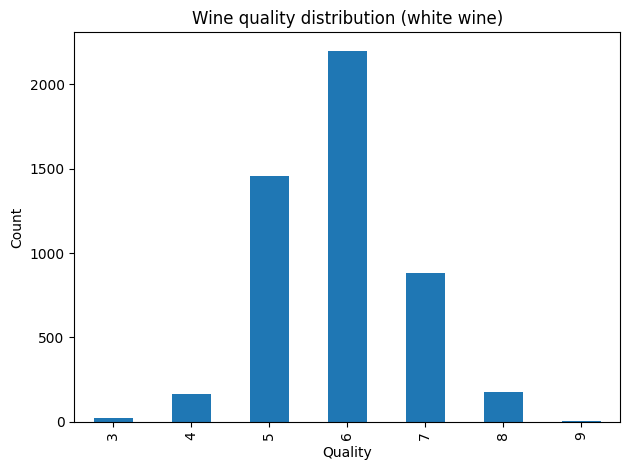

In [2]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

from tabpfn import TabPFNRegressor, TabPFNClassifier
from tabicl import TabICLClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

path = "./data/winequality-white.csv"
df = pd.read_csv(path, sep=";")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

target_col = "quality"
quality_counts = df[target_col].value_counts().sort_index()
print("\nQuality value counts:\n", quality_counts)

feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

plt.figure()
quality_counts.plot(kind="bar")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Wine quality distribution (white wine)")
plt.tight_layout()
plt.show()

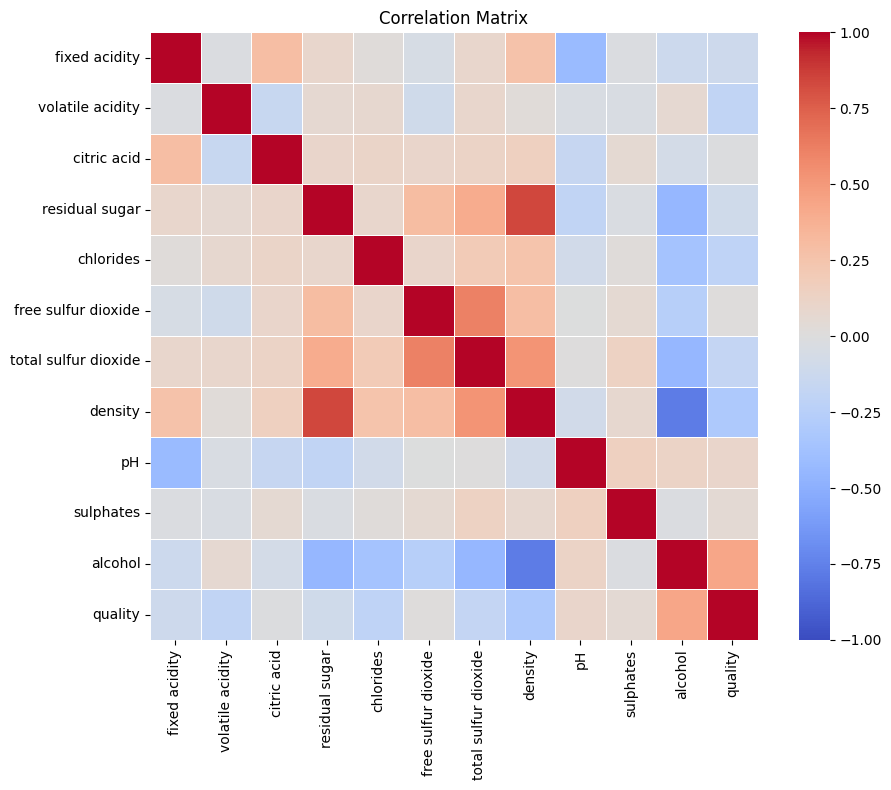

In [3]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [4]:
def timed_fit_predict(model, X_tr, y_tr, X_te):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    y_hat = model.predict(X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    return y_hat, fit_s, pred_s

### TabPFN (Regressor)

In [5]:
fold_summaries = []
all_y_true, all_y_pred = [], []

kf = KFold(n_splits=5, shuffle=True, random_state=21)

rmses, maes, r2s = [], [], []
fit_times, pred_times = [], []

warm_model = TabPFNRegressor(device="cuda")
_ = warm_model.fit(X.iloc[:256], y.iloc[:256])
_ = warm_model.predict(X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

    model = TabPFNRegressor(device="cuda")
    y_hat, fit_s, pred_s = timed_fit_predict(model, X_tr, y_tr, X_te)

    rmse = root_mean_squared_error(y_te, y_hat)
    mae = mean_absolute_error(y_te, y_hat)
    r2 = r2_score(y_te, y_hat)

    rmses.append(rmse); maes.append(mae); r2s.append(r2)
    fit_times.append(fit_s); pred_times.append(pred_s)

    fold_summaries.append(
        {"fold": fold, "rmse": rmse, "mae": mae, "r2": r2, "fit_s": fit_s, "pred_s": pred_s}
    )
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(np.asarray(y_hat))

    print(f"Fold {fold}: RMSE={rmse:.4f} MAE={mae:.4f} R2={r2:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

print(
    f"\nTabPFN 5-fold CV: RMSE = {np.mean(rmses):.4f} ± {np.std(rmses):.4f}, "
    f"MAE = {np.mean(maes):.4f} ± {np.std(maes):.4f}, "
    f"R2 = {np.mean(r2s):.4f} ± {np.std(r2s):.4f}"
)
print(
    f"Timing: fit = {np.mean(fit_times):.2f}s ± {np.std(fit_times):.2f}, "
    f"predict = {np.mean(pred_times):.2f}s ± {np.std(pred_times):.2f}"
)

Fold 1: RMSE=0.5996 MAE=0.4383 R2=0.5172 | fit=0.366s pred=1.823s
Fold 2: RMSE=0.6080 MAE=0.4447 R2=0.5147 | fit=0.303s pred=1.782s
Fold 3: RMSE=0.6195 MAE=0.4659 R2=0.5064 | fit=0.281s pred=1.794s
Fold 4: RMSE=0.6235 MAE=0.4573 R2=0.5306 | fit=0.291s pred=1.799s
Fold 5: RMSE=0.6482 MAE=0.4607 R2=0.4796 | fit=0.319s pred=1.806s

TabPFN 5-fold CV: RMSE = 0.6198 ± 0.0165, MAE = 0.4534 ± 0.0103, R2 = 0.5097 ± 0.0169
Timing: fit = 0.31s ± 0.03, predict = 1.80s ± 0.01


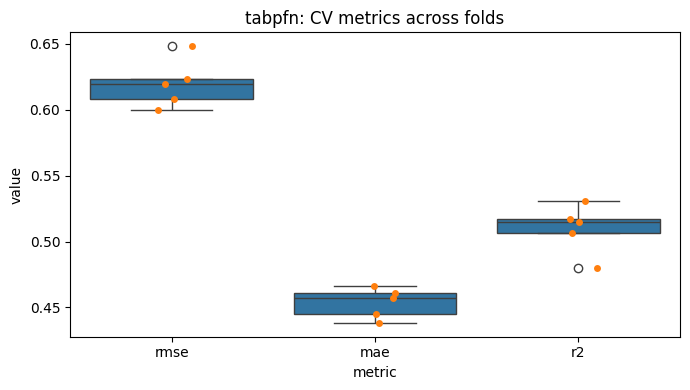

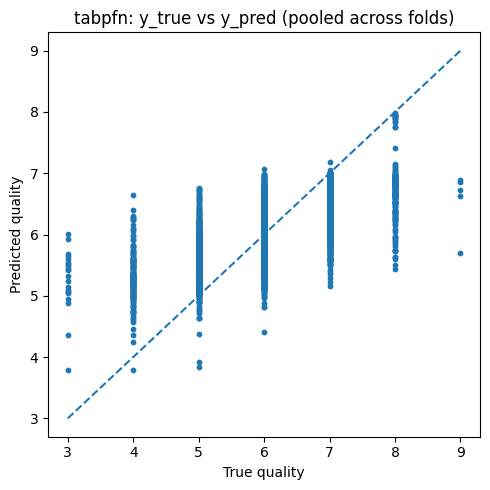

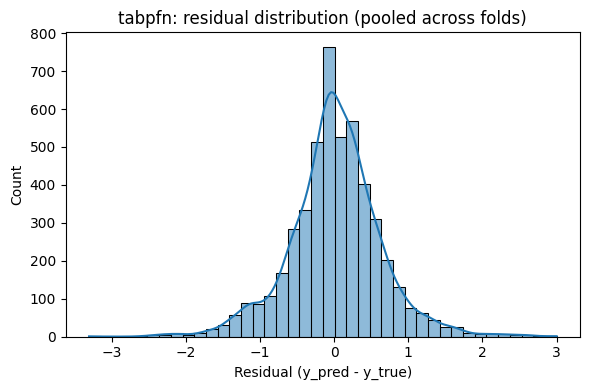

In [6]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": pd.DataFrame(fold_summaries),
    "y_true_cv": np.concatenate(all_y_true).astype(float),
    "y_pred_cv": np.concatenate(all_y_pred).astype(float),
}

cv_metrics_df = MODEL_RESULTS[model_name]["cv_metrics_df"]
y_true_cv = MODEL_RESULTS[model_name]["y_true_cv"]
y_pred_cv = MODEL_RESULTS[model_name]["y_pred_cv"]

cv_metrics_long_df = cv_metrics_df.melt(
    id_vars=["fold"],
    value_vars=["rmse", "mae", "r2"],
    var_name="metric",
    value_name="value",
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=cv_metrics_long_df, x="metric", y="value")
sns.stripplot(data=cv_metrics_long_df, x="metric", y="value", jitter=True, size=5)
plt.title(f"{model_name}: CV metrics across folds")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y_true_cv, y_pred_cv, s=10)
mn = float(min(y_true_cv.min(), y_pred_cv.min()))
mx = float(max(y_true_cv.max(), y_pred_cv.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("True quality")
plt.ylabel("Predicted quality")
plt.title(f"{model_name}: y_true vs y_pred (pooled across folds)")
plt.tight_layout()
plt.show()

residuals_cv = y_pred_cv - y_true_cv
plt.figure(figsize=(6, 4))
sns.histplot(residuals_cv, bins=40, kde=True)
plt.xlabel("Residual (y_pred - y_true)")
plt.title(f"{model_name}: residual distribution (pooled across folds)")
plt.tight_layout()
plt.show()


## Plot Function

In [7]:
def plot_model_results(model_name):
    res = MODEL_RESULTS[model_name]
    cv_metrics_df = res["cv_metrics_df"]
    y_true_cv = res["y_true_cv"]
    y_pred_cv = res["y_pred_cv"]
    y_proba_cv = res["y_proba_cv"]

    metrics_long = cv_metrics_df.melt(
        id_vars=["fold"],
        value_vars=["acc", "auc"],
        var_name="metric",
        value_name="value",
    )
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=metrics_long, x="metric", y="value")
    sns.stripplot(data=metrics_long, x="metric", y="value", jitter=True, size=5)
    plt.title(f"{model_name}: CV metrics across folds")
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_true_cv, y_pred_cv)
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name}: Confusion matrix (pooled)")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"{model_name}: ROC curve (pooled)")
    plt.tight_layout()
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true_cv, y_proba_cv)
    ap = average_precision_score(y_true_cv, y_proba_cv)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name}: Precision–Recall curve (AP={ap:.3f})")
    plt.tight_layout()
    plt.show()

    bins = np.linspace(0.0, 1.0, 11)
    bin_ids = np.digitize(y_proba_cv, bins) - 1

    bin_centers, frac_pos = [], []
    for b in range(len(bins) - 1):
        m = bin_ids == b
        if m.sum() == 0:
            continue
        bin_centers.append((bins[b] + bins[b + 1]) / 2)
        frac_pos.append(y_true_cv[m].mean())

    plt.figure(figsize=(5, 4))
    plt.plot(bin_centers, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Predicted probability (bin center)")
    plt.ylabel("Empirical P(y=1)")
    plt.title(f"{model_name}: Reliability curve (pooled)")
    plt.tight_layout()
    plt.show()

### TabPFN (Classifier)

In [8]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabpfn"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

warm_model = TabPFNClassifier(device="cuda")
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = get_pos_proba(warm_model, X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabPFNClassifier(device="cuda")

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)


Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268
Fold 1: ACC=0.8847 AUC=0.9402 | fit=0.274s pred=1.979s
Fold 2: ACC=0.8745 AUC=0.9165 | fit=0.268s pred=1.949s
Fold 3: ACC=0.8949 AUC=0.9311 | fit=0.275s pred=1.946s
Fold 4: ACC=0.8713 AUC=0.9024 | fit=0.267s pred=1.949s
Fold 5: ACC=0.8784 AUC=0.9241 | fit=0.261s pred=1.892s

tabpfn 5-fold CV: ACC=0.8808±0.0093, AUC=0.9229±0.0144
Timing: fit=0.27s±0.01, predict=1.94s±0.03


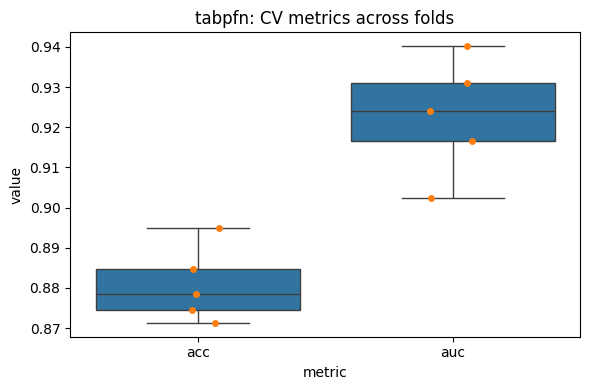

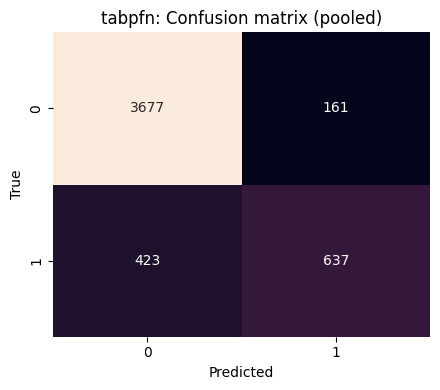

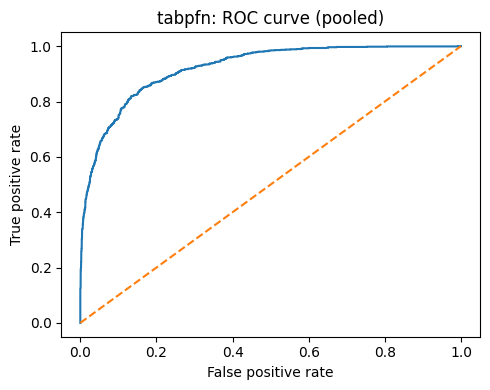

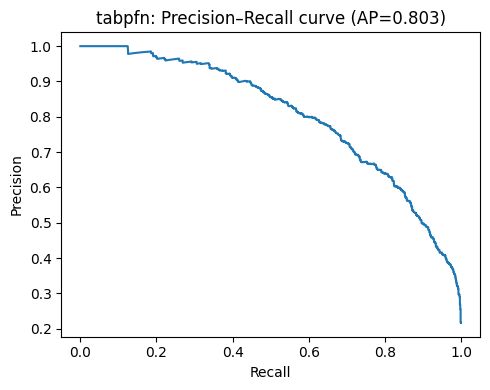

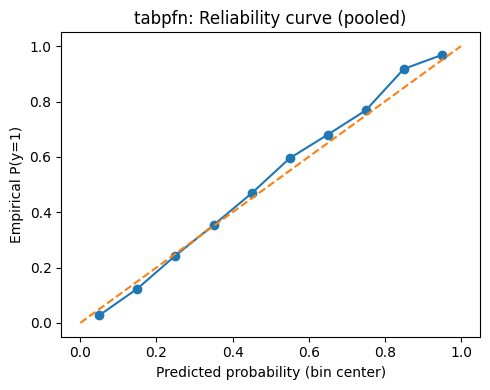

In [9]:
plot_model_results("tabpfn")

### TabICL

In [10]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

model_name = "tabicl"
y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def get_pos_proba(model, X_):
    proba = model.predict_proba(X_)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

fold_summaries = []
all_y_true, all_y_pred, all_y_proba = [], [], []

warm_model = TabICLClassifier()
_ = warm_model.fit(X.iloc[:256], y_bin.iloc[:256])
_ = get_pos_proba(warm_model, X.iloc[:256])
if torch.cuda.is_available():
    torch.cuda.synchronize()

for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

    model = TabICLClassifier()

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    fit_s = time.perf_counter() - t0

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    proba = get_pos_proba(model, X_te)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    pred_s = time.perf_counter() - t0

    y_hat = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, y_hat)
    auc = roc_auc_score(y_te, proba)

    fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
    all_y_true.append(y_te.to_numpy())
    all_y_pred.append(y_hat)
    all_y_proba.append(proba)

    print(f"Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

cv_metrics_df = pd.DataFrame(fold_summaries)
y_true_cv = np.concatenate(all_y_true)
y_pred_cv = np.concatenate(all_y_pred)
y_proba_cv = np.concatenate(all_y_proba)

MODEL_RESULTS[model_name] = {
    "cv_metrics_df": cv_metrics_df,
    "y_true_cv": y_true_cv,
    "y_pred_cv": y_pred_cv,
    "y_proba_cv": y_proba_cv,
}

print(
    f"\n{model_name} 5-fold CV: "
    f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
    f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
)
print(
    f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
    f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
)


Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268
Fold 1: ACC=0.8939 AUC=0.9458 | fit=0.689s pred=2.928s
Fold 2: ACC=0.8786 AUC=0.9290 | fit=0.487s pred=2.948s
Fold 3: ACC=0.8990 AUC=0.9375 | fit=0.502s pred=2.904s
Fold 4: ACC=0.8754 AUC=0.9127 | fit=0.492s pred=2.879s
Fold 5: ACC=0.8795 AUC=0.9335 | fit=0.485s pred=2.874s

tabicl 5-fold CV: ACC=0.8853±0.0105, AUC=0.9317±0.0123
Timing: fit=0.53s±0.09, predict=2.91s±0.03


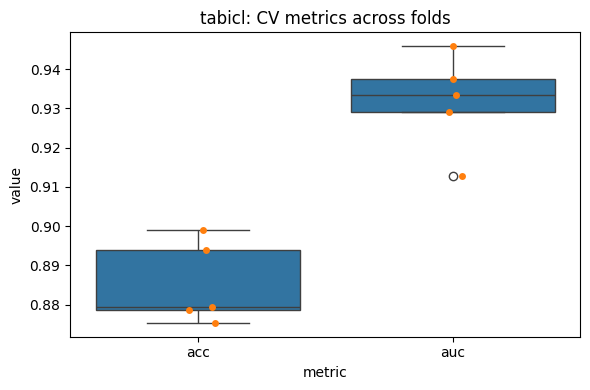

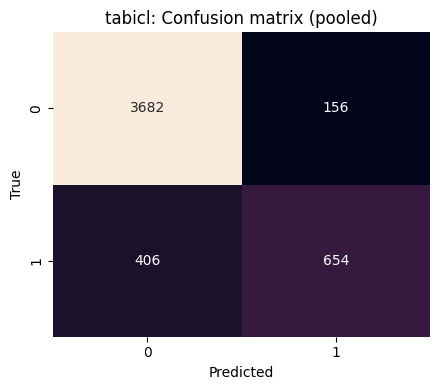

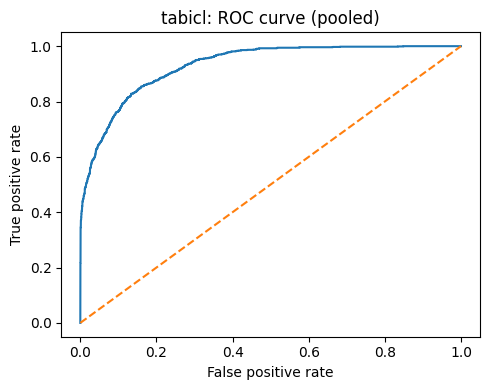

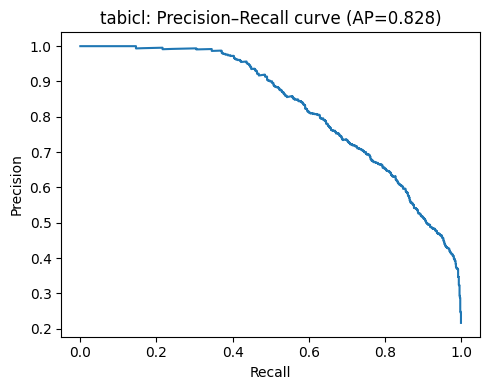

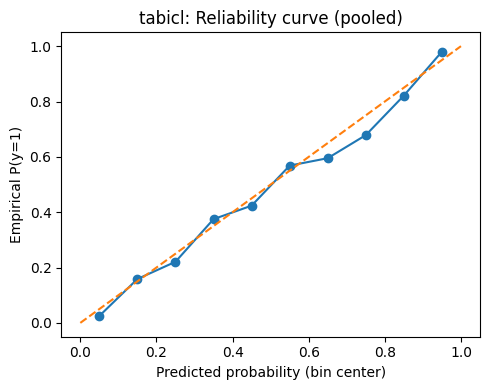

In [11]:
plot_model_results("tabicl")

### Random Forest, XGBoost, CatBoost and LightGBM

In [12]:
MODEL_RESULTS = globals().get("MODEL_RESULTS", {})

y_bin = (y >= 7).astype(int)

p = y_bin.mean()
print("Positive rate (quality>=7):", p)
print("Majority baseline accuracy:", max(p, 1 - p))
print(55 * "-")

kf = KFold(n_splits=5, shuffle=True, random_state=20)

def _get_pos_proba(model, X_te):
    proba = model.predict_proba(X_te)
    if hasattr(proba, "detach"):
        proba = proba.detach().cpu().numpy()
    if isinstance(proba, list):
        proba = np.asarray(proba)
    proba = np.asarray(proba)
    if proba.ndim == 2 and proba.shape[1] >= 2:
        return proba[:, 1]
    return proba.reshape(-1)

def run_cv(model_name, make_model):
    fold_summaries = []
    all_y_true, all_y_pred, all_y_proba = [], [], []

    warm = make_model()
    warm.fit(X.iloc[:256], y_bin.iloc[:256])
    _ = _get_pos_proba(warm, X.iloc[:256])

    for fold, (tr_idx, te_idx) in enumerate(kf.split(X), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_bin.iloc[tr_idx], y_bin.iloc[te_idx]

        model = make_model()

        t0 = time.perf_counter()
        model.fit(X_tr, y_tr)
        fit_s = time.perf_counter() - t0

        t0 = time.perf_counter()
        proba = _get_pos_proba(model, X_te)
        pred_s = time.perf_counter() - t0

        y_hat = (proba >= 0.5).astype(int)

        acc = accuracy_score(y_te, y_hat)
        auc = roc_auc_score(y_te, proba)

        fold_summaries.append({"fold": fold, "acc": acc, "auc": auc, "fit_s": fit_s, "pred_s": pred_s})
        all_y_true.append(y_te.to_numpy())
        all_y_pred.append(y_hat)
        all_y_proba.append(proba)

        print(f"{model_name} Fold {fold}: ACC={acc:.4f} AUC={auc:.4f} | fit={fit_s:.3f}s pred={pred_s:.3f}s")

    cv_metrics_df = pd.DataFrame(fold_summaries)
    y_true_cv = np.concatenate(all_y_true)
    y_pred_cv = np.concatenate(all_y_pred)
    y_proba_cv = np.concatenate(all_y_proba)

    MODEL_RESULTS[model_name] = {
        "cv_metrics_df": cv_metrics_df,
        "y_true_cv": y_true_cv,
        "y_pred_cv": y_pred_cv,
        "y_proba_cv": y_proba_cv,
    }

    print(
        f"\n{model_name} 5-fold CV: "
        f"ACC={cv_metrics_df['acc'].mean():.4f}±{cv_metrics_df['acc'].std():.4f}, "
        f"AUC={cv_metrics_df['auc'].mean():.4f}±{cv_metrics_df['auc'].std():.4f}"
    )
    print(
        f"Timing: fit={cv_metrics_df['fit_s'].mean():.2f}s±{cv_metrics_df['fit_s'].std():.2f}, "
        f"predict={cv_metrics_df['pred_s'].mean():.2f}s±{cv_metrics_df['pred_s'].std():.2f}"
    )
    print(55 * "-")

models_to_run = {}

models_to_run["rf"] = lambda: RandomForestClassifier(random_state=20, n_jobs=-1)

models_to_run["xgb"] = lambda: XGBClassifier(random_state=20, n_jobs=-1)

models_to_run["cat"] = lambda: CatBoostClassifier(random_seed=20, verbose=False)

models_to_run["lgbm"] = lambda: LGBMClassifier(random_state=20, n_jobs=-1, verbose=-1)

for name, factory in models_to_run.items():
    run_cv(name, factory)

Positive rate (quality>=7): 0.21641486320947326
Majority baseline accuracy: 0.7835851367905268
-------------------------------------------------------
rf Fold 1: ACC=0.8867 AUC=0.9311 | fit=0.291s pred=0.050s
rf Fold 2: ACC=0.8735 AUC=0.9163 | fit=0.275s pred=0.050s
rf Fold 3: ACC=0.8888 AUC=0.9158 | fit=0.269s pred=0.050s
rf Fold 4: ACC=0.8764 AUC=0.9003 | fit=0.269s pred=0.049s
rf Fold 5: ACC=0.8815 AUC=0.9187 | fit=0.277s pred=0.050s

rf 5-fold CV: ACC=0.8814±0.0065, AUC=0.9164±0.0110
Timing: fit=0.28s±0.01, predict=0.05s±0.00
-------------------------------------------------------
xgb Fold 1: ACC=0.8929 AUC=0.9127 | fit=0.052s pred=0.002s
xgb Fold 2: ACC=0.8561 AUC=0.8870 | fit=0.052s pred=0.002s
xgb Fold 3: ACC=0.8806 AUC=0.9144 | fit=0.049s pred=0.002s
xgb Fold 4: ACC=0.8539 AUC=0.8773 | fit=0.046s pred=0.002s
xgb Fold 5: ACC=0.8672 AUC=0.8978 | fit=0.045s pred=0.002s

xgb 5-fold CV: ACC=0.8701±0.0165, AUC=0.8979±0.0161
Timing: fit=0.05s±0.00, predict=0.00s±0.00
-----------------

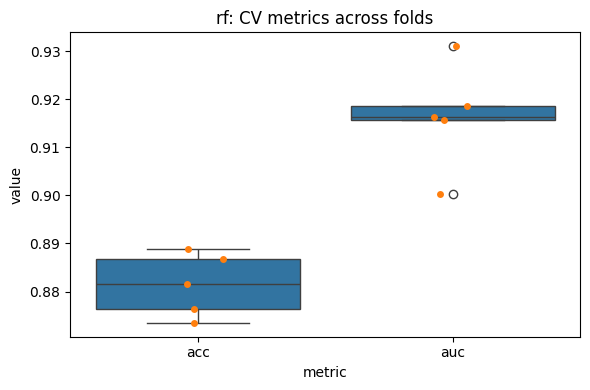

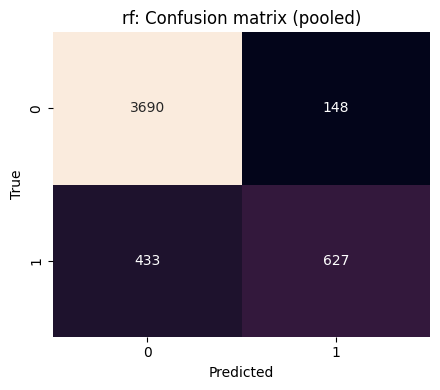

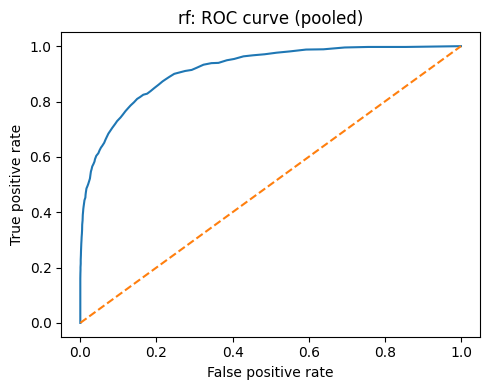

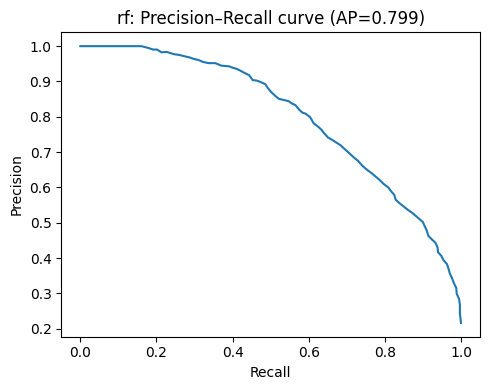

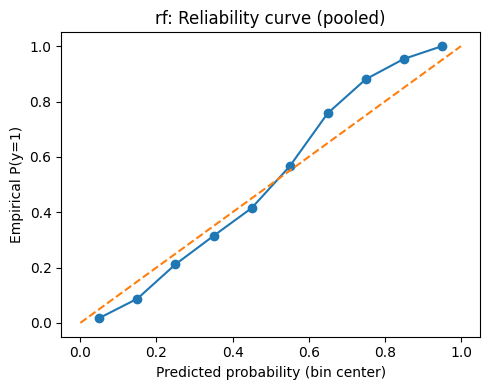

In [13]:
plot_model_results("rf")

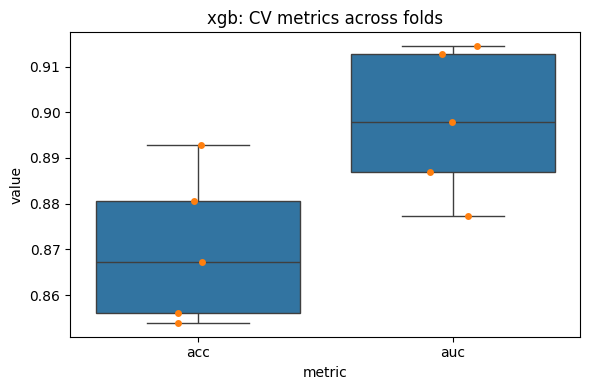

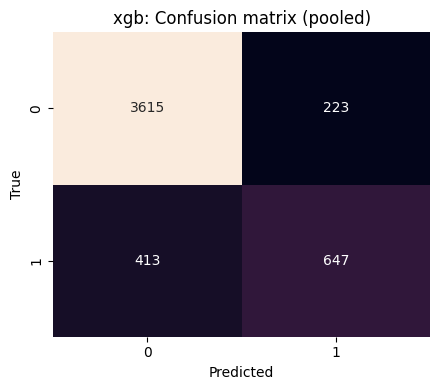

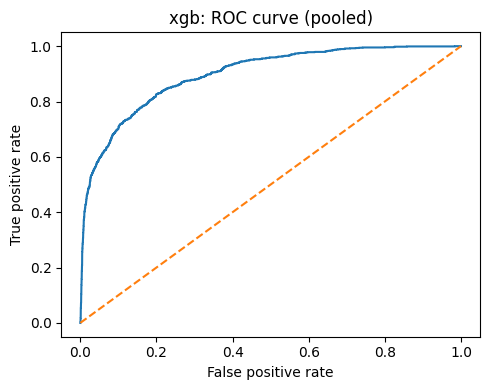

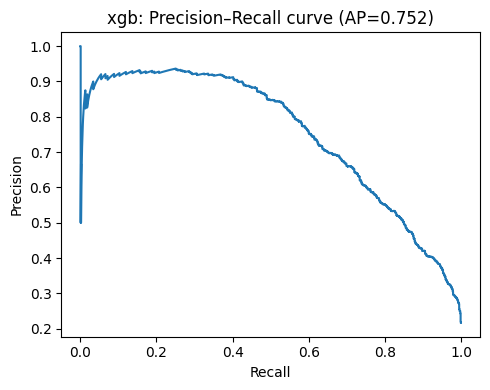

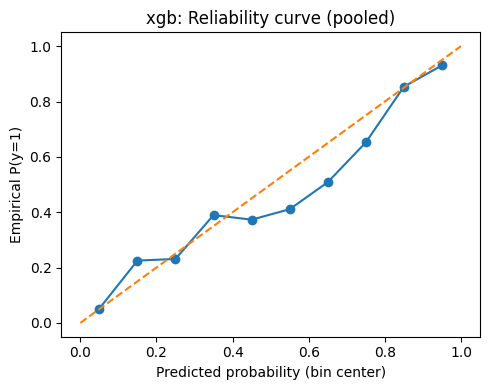

In [14]:
plot_model_results("xgb")

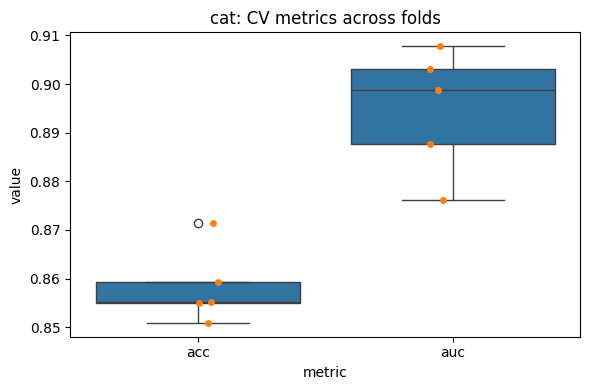

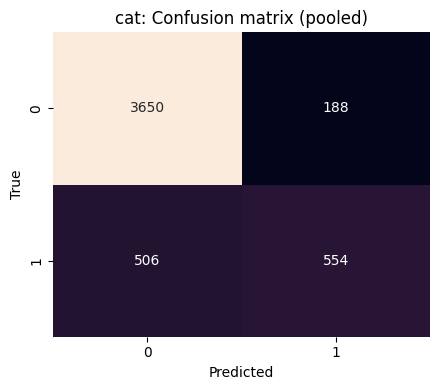

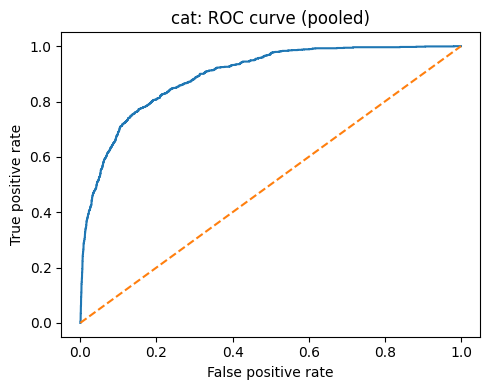

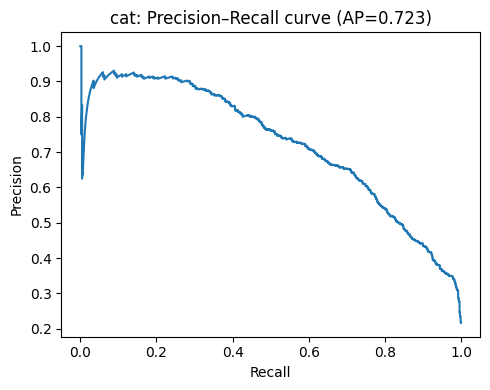

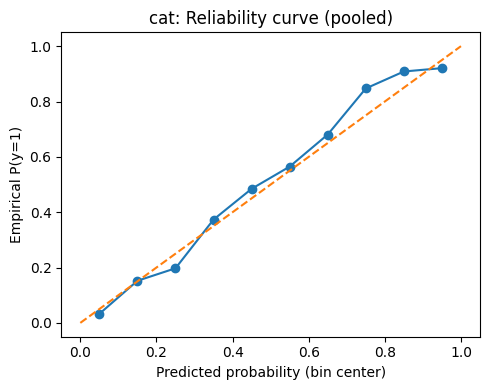

In [15]:
plot_model_results("cat")

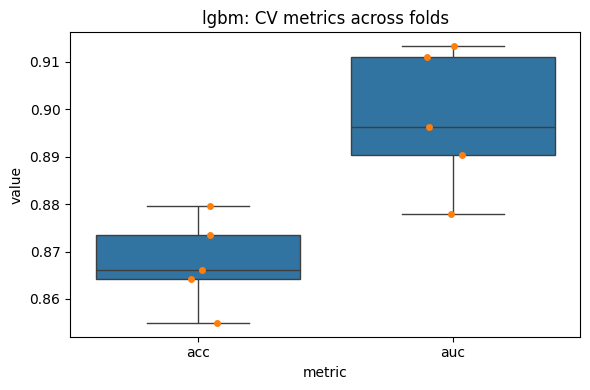

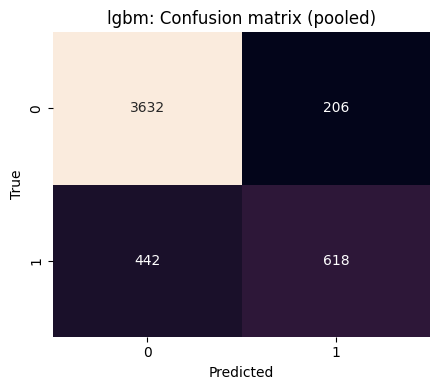

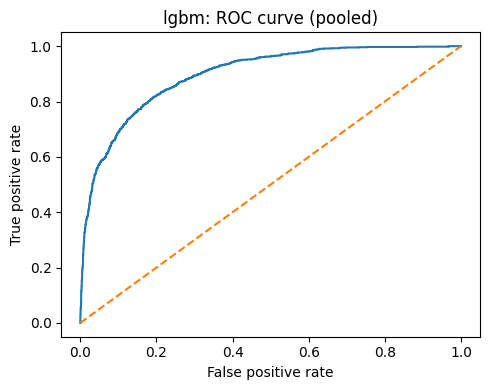

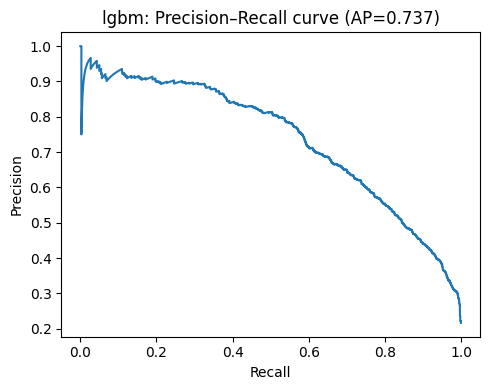

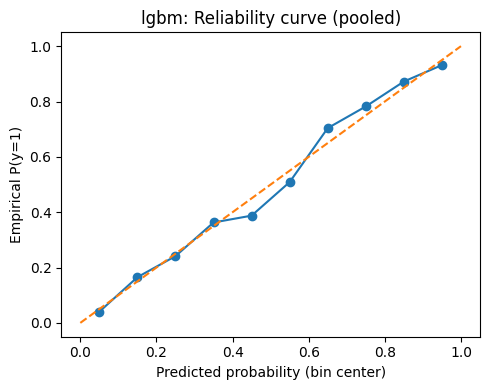

In [16]:
plot_model_results("lgbm")

In [17]:
rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df", None)
    if cv is None or cv.empty:
        continue
    rows.append({
        "model": name,
        "acc_mean": cv["acc"].mean(),
        "acc_std": cv["acc"].std(ddof=1),
        "auc_mean": cv["auc"].mean(),
        "auc_std": cv["auc"].std(ddof=1),
        "fit_s_mean": cv["fit_s"].mean() if "fit_s" in cv.columns else None,
        "pred_s_mean": cv["pred_s"].mean() if "pred_s" in cv.columns else None,
        "n_folds": int(cv.shape[0]),
    })

summary_df = pd.DataFrame(rows).sort_values("auc_mean", ascending=False).reset_index(drop=True)

for c in ["acc_mean", "acc_std", "auc_mean", "auc_std", "fit_s_mean", "pred_s_mean"]:
    if c in summary_df.columns:
        summary_df[c] = summary_df[c].astype(float)

display(summary_df.style.format({
    "acc_mean": "{:.4f}",
    "acc_std": "{:.4f}",
    "auc_mean": "{:.4f}",
    "auc_std": "{:.4f}",
    "fit_s_mean": "{:.3f}",
    "pred_s_mean": "{:.3f}",
}))


,model,acc_mean,acc_std,auc_mean,auc_std,fit_s_mean,pred_s_mean,n_folds
0,tabicl,0.8853,0.0105,0.9317,0.0123,0.531,2.907,5
1,tabpfn,0.8808,0.0093,0.9229,0.0144,0.269,1.943,5
2,rf,0.8814,0.0065,0.9164,0.0110,0.276,0.050,5
3,xgb,0.8701,0.0165,0.8979,0.0161,0.049,0.002,5
4,lgbm,0.8677,0.0094,0.8978,0.0147,0.088,0.002,5
5,cat,0.8583,0.0079,0.8947,0.0128,2.359,0.002,5


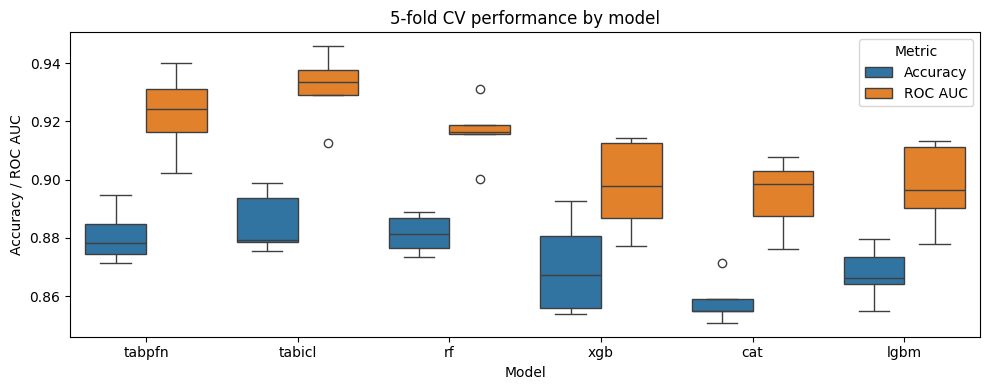

In [22]:

rows = []
for name, res in MODEL_RESULTS.items():
    cv = res.get("cv_metrics_df")
    if cv is None or cv.empty:
        continue
    tmp = cv.copy()
    tmp["model"] = name
    rows.append(tmp)

cv_all = pd.concat(rows, ignore_index=True)

m_long = cv_all.melt(
    id_vars=["model", "fold"],
    value_vars=["acc", "auc"],
    var_name="metric",
    value_name="value",
)

metric_names = {"acc": "Accuracy", "auc": "ROC AUC"}
m_long["metric"] = m_long["metric"].map(metric_names)

plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=m_long, x="model", y="value", hue="metric")

ax.set_xlabel("Model")
ax.set_ylabel("Accuracy / ROC AUC")
ax.set_title("5-fold CV performance by model")

ax.legend(title="Metric", loc="upper right", frameon=True)

plt.tight_layout()
plt.show()
